In [1]:
dataset <- "ARPAL"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Liguria"
match_dist <- 15000
new_dataset <- "LIG"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 10000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Piemonte", "Emilia-Romagna", "Toscana"), network != "DPC")
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [6]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(0L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", state, "raw_analysis.parquet"))

In [13]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    tag_mergeable() |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [14]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, merging_datasets, desc(dataset), desc(sensor_last))
ignore_corrections <- NULL
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 30L, 0.5, ignore_corrections)


In [15]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i

pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
62,-1.6480974,-0.6789848,0.21061690,0.06069100,75,99,329,-1,0,LOCO CARCHELLI,ARPAL,99,Loco Carchelli,Idrografica,1577
63,-0.6838009,-1.2354369,0.22384029,-0.05799224,75,99,329,1,0,LOCO CARCHELLI,ARPAL,99,Loco Carchelli,Idrografica,1577
287,-0.8515616,-0.8802723,-0.46633714,-0.01488589,144,194,191,-1,0,ALBENGA,Sinottica,17,NA,ISAC,4036
2,1.3918367,0.0000000,0.00000000,0.00000000,1,1,2,1,0,AIROLE,ARPAL,1,AIROLE,ARPAL,2
256,-0.7831633,-0.2578482,-0.03787872,0.15892521,128,166,165,1,0,STATALE,ARPAL,166,STATALE,ARPAL,165
1,-0.8463576,0.0000000,0.00000000,0.00000000,1,1,2,-1,0,AIROLE,ARPAL,1,AIROLE,ARPAL,2
34,-0.3940191,-0.4272928,-0.02930319,0.04525158,17,25,24,1,0,CAMOGLI,ARPAL,25,CAMOGLI,ARPAL,24
290,0.5496639,-0.0482647,0.01775949,0.05457263,145,410,192,1,0,SARZANA/LUNI,Sinottica,2782,NA,ISAC,4038
32,0.2977865,-1.2805799,-0.09383780,-0.08482775,16,23,22,1,0,CALICE LIGURE - CA ROSSE,ARPAL,23,CALICE LIGURE,ARPAL,22


In [16]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations)
rm(merge_results)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2191930,117.1,5206444,278.1,NA,5206444,278.1
Vcells,24106824,184.0,106073448,809.3,16384,132590954,1011.6


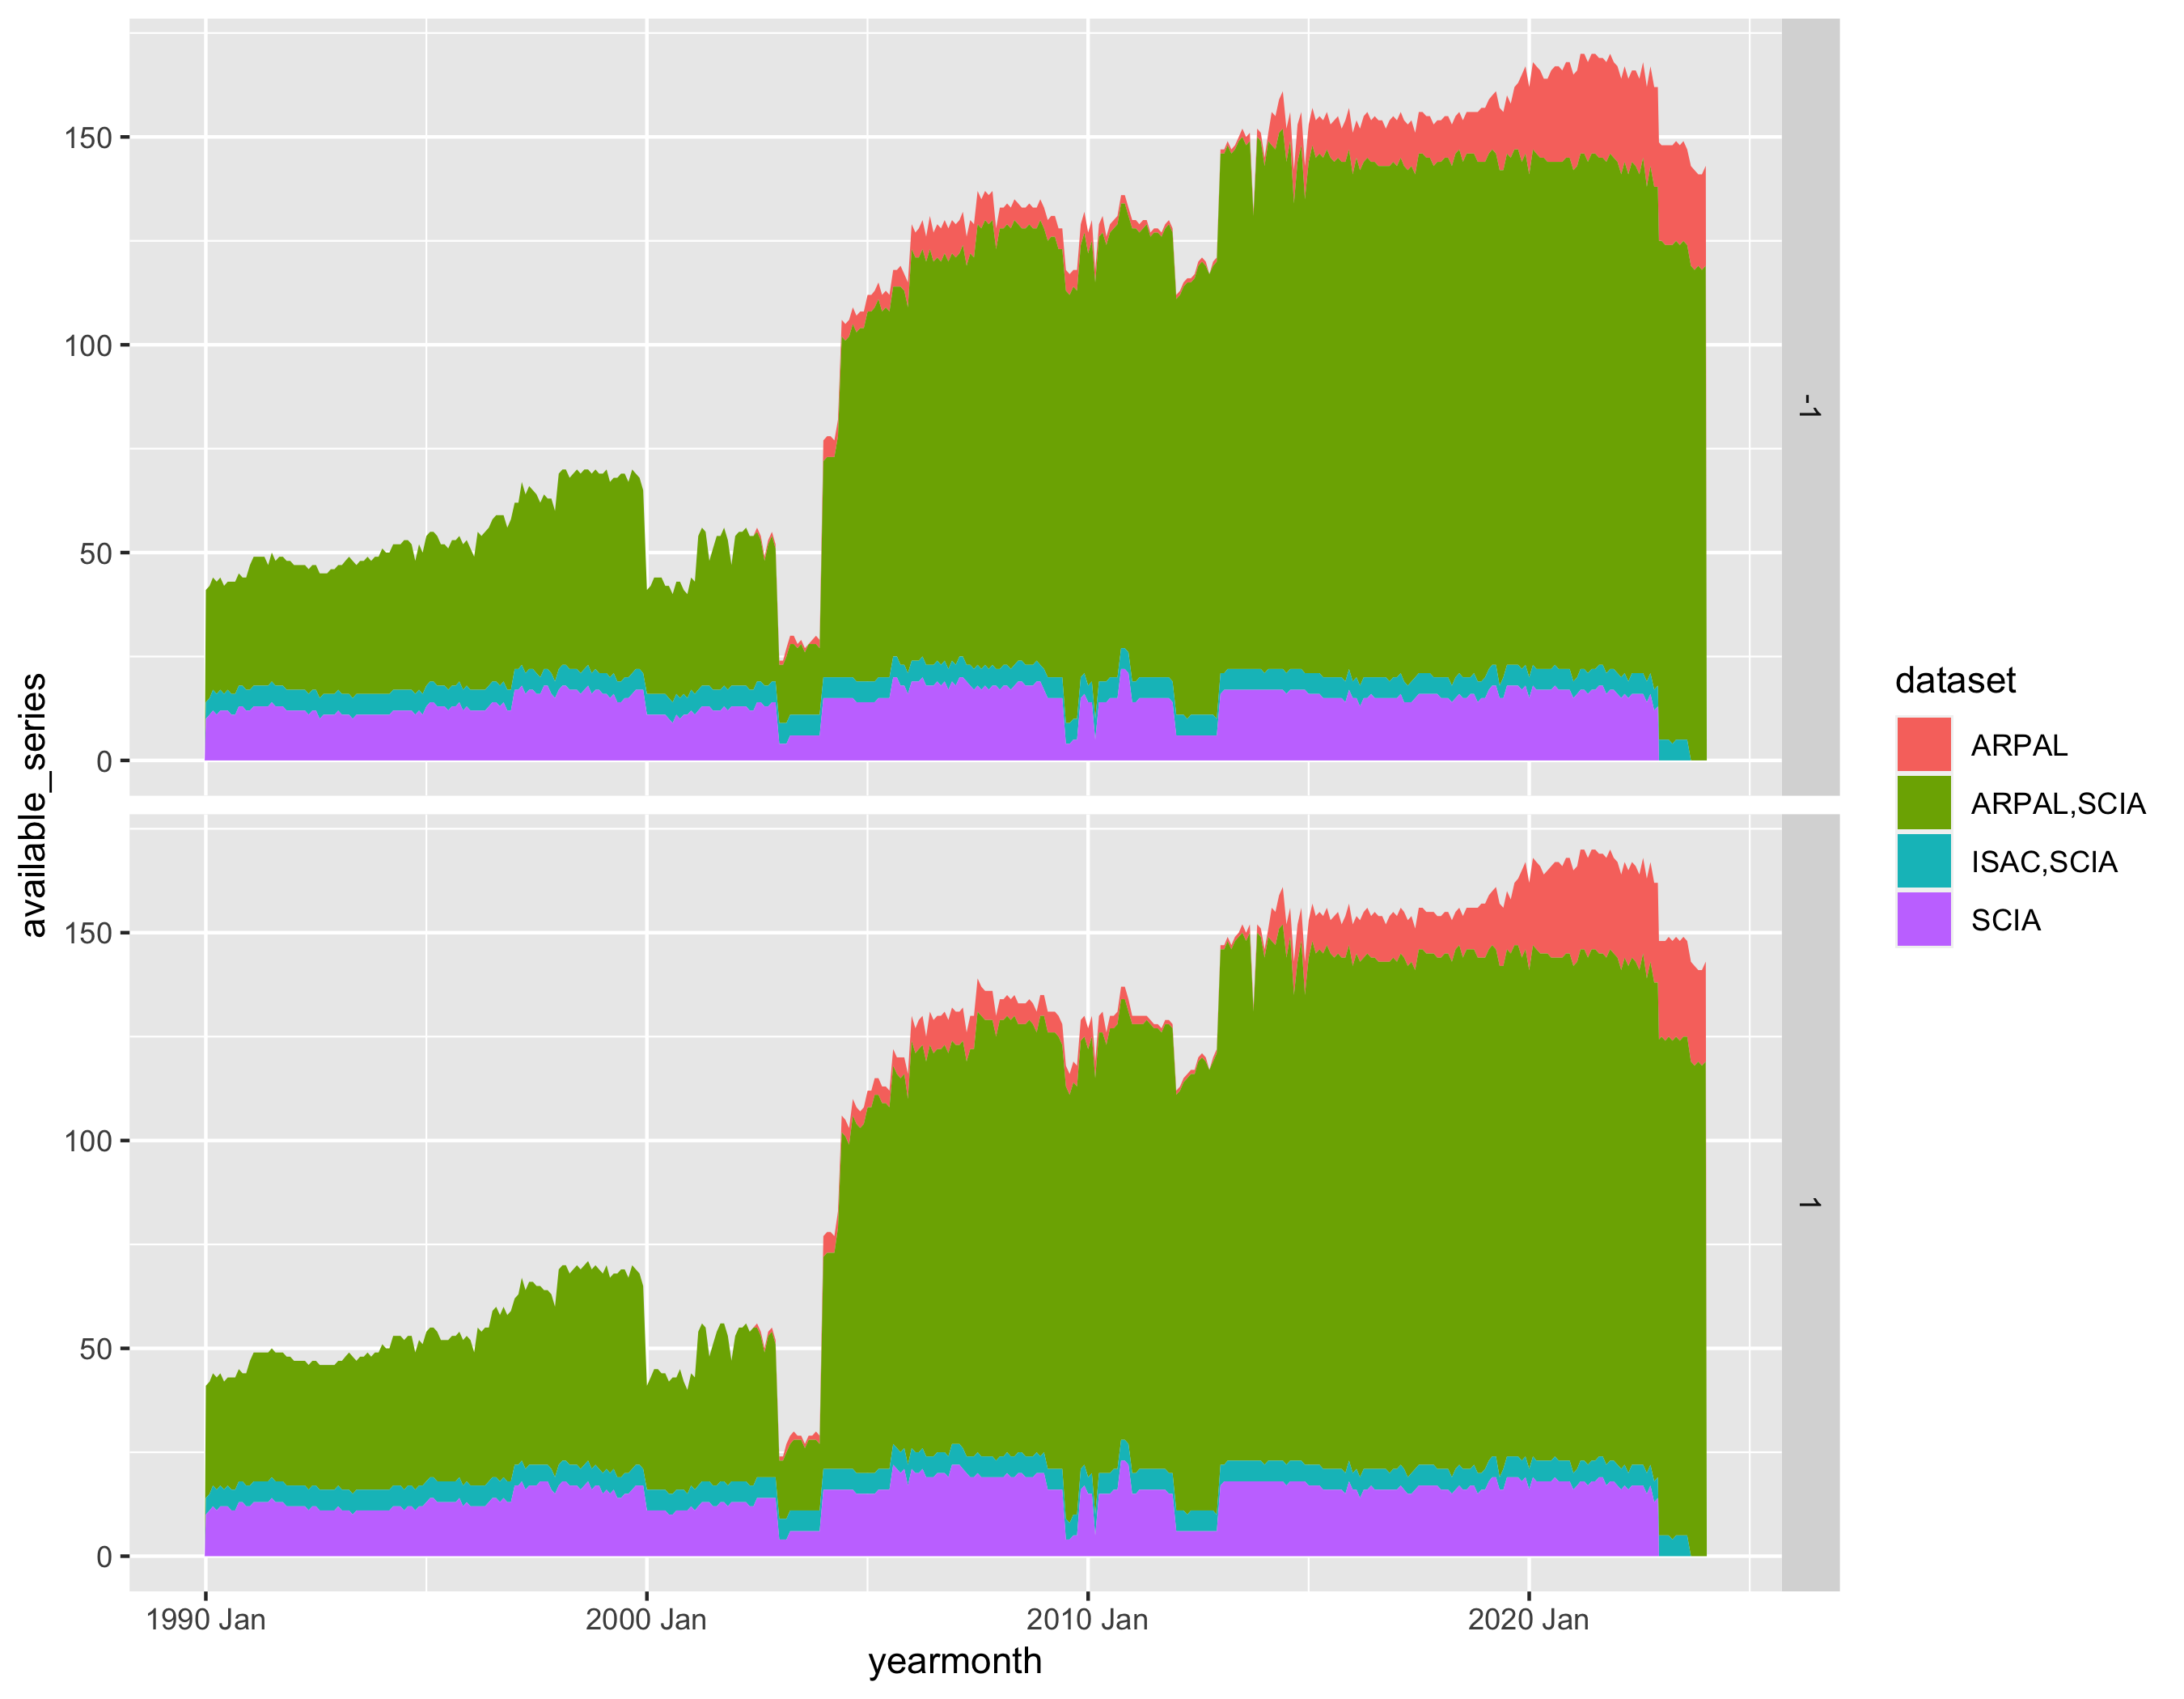

In [17]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |> select(sensor_key, from_datasets) |> collect() |> rowwise() |> mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |> ungroup() |> select(-from_datasets)
dt <- db$data |> select(-dataset) |> left_join(mt, by = "sensor_key", copy = TRUE) |> filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)

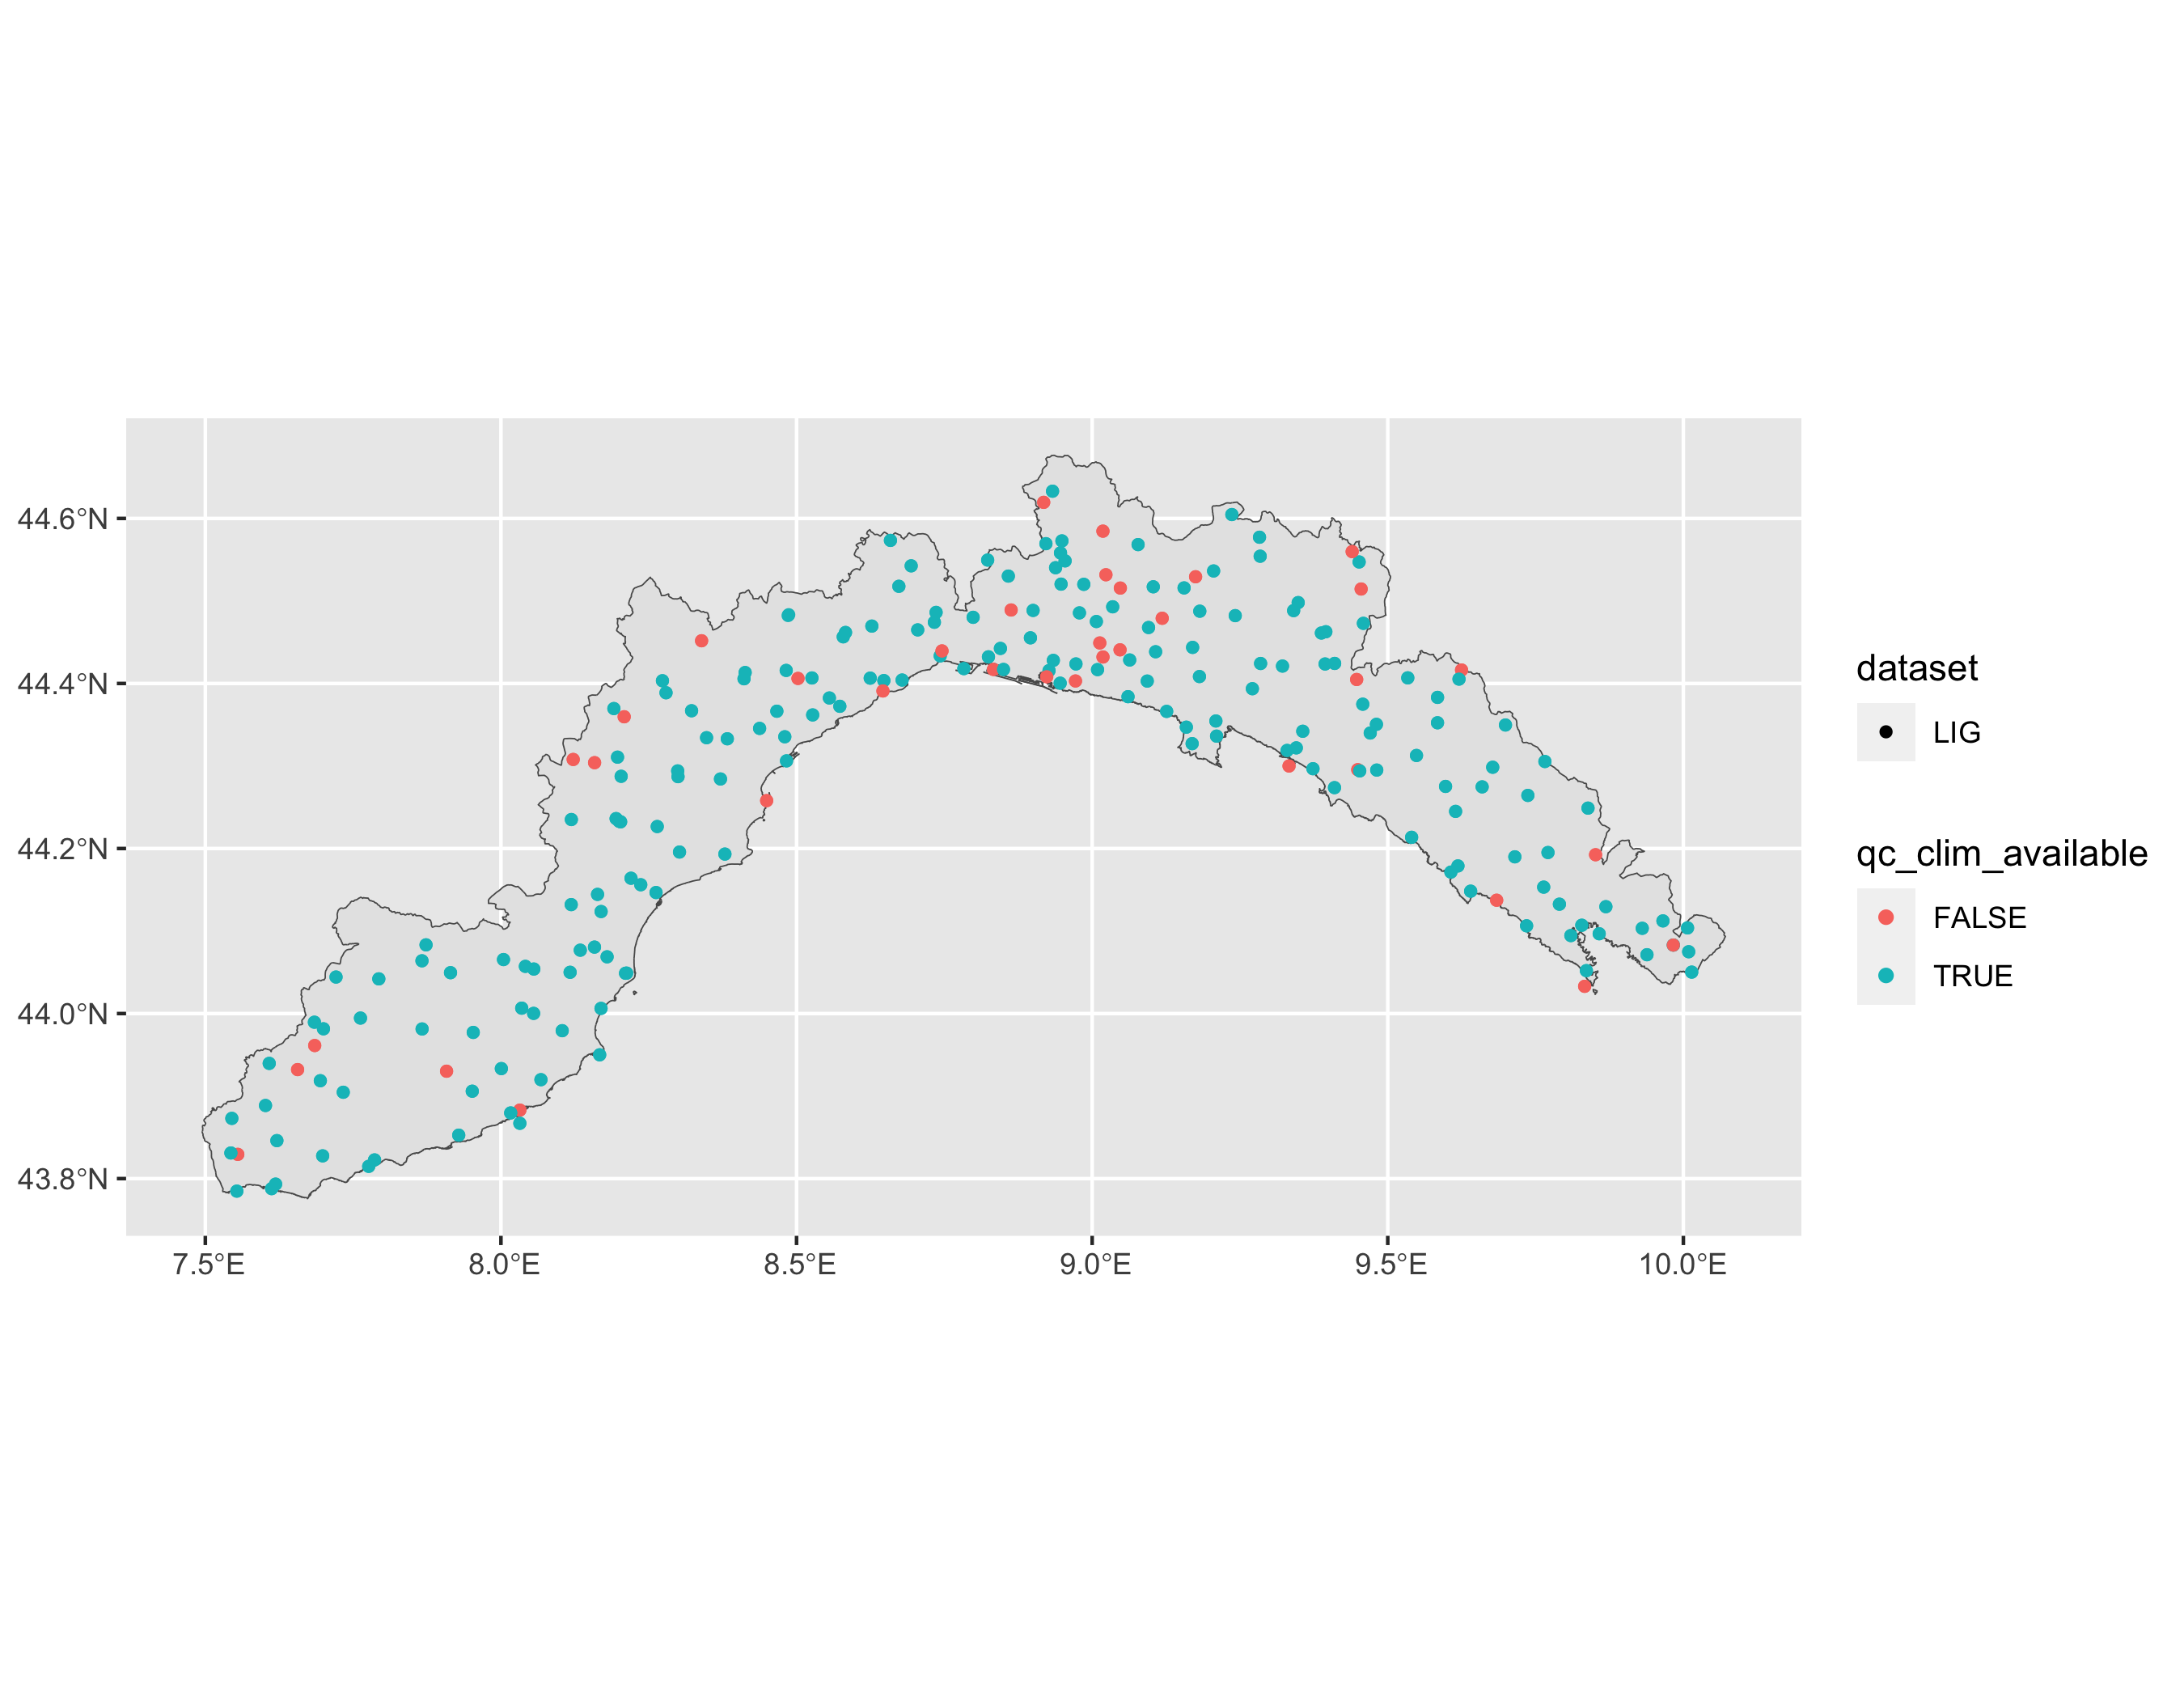

In [18]:
sp_data <- pd$data |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot 